In [196]:
import datetime
import math
import random


START_DATE = "start_Date"
END_DATE = "end_Date"
CAR_DELAY = "car_delay"
CAR_SEMAPHOR_DELAY = "car_semaphore_delay"
WALKER_DELAY = "walker_delay"
WALKER_SEMAPHOR_DELAY = "walker_semaphore_delay"


class StatObject:
    def __init__(self, name : str, start_Date : datetime, end_Date : datetime, car_delay : list[int], car_semaphor_delay : list[int], walker_delay : list[int], walker_semaphor_delay : list[int]):
        self.name = name
        self.values = {
            START_DATE : start_Date,
            END_DATE : end_Date,
            CAR_DELAY : car_delay,
            CAR_SEMAPHOR_DELAY : car_semaphor_delay,
            WALKER_DELAY : walker_delay,
            WALKER_SEMAPHOR_DELAY : walker_semaphor_delay
        }

    @staticmethod
    def plot_matrix_p_values_heat_map(name : str, matrix : list[list[float]]):
        """
        Given a matrix of p-values plot it with a heat-map  ( this p-values idea came from a POstHocTest)
        """
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np

        fig, ax = plt.subplots(figsize=(10, 10))
        ax = sns.heatmap(np.array(matrix), annot=True, fmt=".2f", cmap='coolwarm', ax=ax, vmin=0, vmax=1)
        ax.set_title(name)
        plt.savefig(f"heat_map {name}.png")
        plt.show()

    @staticmethod
    def average_plotter( group1 : tuple[list['StatObject'], str] , group2 : tuple[list['StatObject'], str]):
        """
        Plot the average of the stats.
        """
        import matplotlib.pyplot as plt

        name_1 = group1[1]
        name_2 = group2[1]

        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.tight_layout(pad=3.0)

        def average(data):
            return sum(data) / len(data)

        car_delay_values_group1 = [ average(StatObject.remove_outliers( x.values[CAR_DELAY] )) for x in group1[0] ]
        car_delay_values_group2 = [ average(StatObject.remove_outliers( x.values[CAR_DELAY] )) for x in group2[0] ]

        car_semaphore_delay_group1 = [ average(StatObject.remove_outliers( x.values[CAR_SEMAPHOR_DELAY] )) for x in group1[0] ]
        car_semaphore_delay_group2 = [ average(StatObject.remove_outliers( x.values[CAR_SEMAPHOR_DELAY] )) for x in group2[0] ]

        walkers_delay_group1 = [ average(StatObject.remove_outliers( x.values[WALKER_DELAY] )) for x in group1[0] ]
        walkers_delay_group2 = [ average(StatObject.remove_outliers( x.values[WALKER_DELAY] )) for x in group2[0] ]

        walker_semaphore_delay_group1 = [ average(StatObject.remove_outliers( x.values[WALKER_SEMAPHOR_DELAY] )) for x in group1[0] ]
        walker_semaphore_delay_group2 = [ average(StatObject.remove_outliers( x.values[WALKER_SEMAPHOR_DELAY] )) for x in group2[0] ]

        pairs = [
            (car_delay_values_group1, car_delay_values_group2, "Car Delay"),
            (car_semaphore_delay_group1, car_semaphore_delay_group2, "Car Semaphore Delay"),
            (walkers_delay_group1, walkers_delay_group2, "Walker Delay"),
            (walker_semaphore_delay_group1, walker_semaphore_delay_group2, "Walker Semaphore Delay")
        ]

        for i, (group1_values, group2_values, title) in enumerate(pairs):
            random.shuffle(group1_values)
            random.shuffle(group2_values)
            axs[i // 2, i % 2].scatter(group1_values, group2_values , color='red')
            axs[i // 2, i % 2].set_title(title)
            axs[i // 2, i % 2].set_xlabel(name_1)
            axs[i // 2, i % 2].set_ylabel(name_2)
            axs[i // 2, i % 2].plot([min(group1_values + group2_values), max(group1_values + group2_values)], 
                                    [min(group1_values + group2_values), max(group1_values + group2_values)], 
                                    color='blue', linestyle='--')
        
        plt.savefig(f"Average {name_1} vs {name_2}.png")
        plt.show()


    @staticmethod
    def transform(data):
        """
        Log the time of the data.
        """
        result = []
        for dt in data:
            if dt == 0:
                result.append(0)
            else:
                result.append(math.log(dt))
        return result

    @staticmethod
    def remove_outliers(data):
        import numpy as np
        """
        Remove outliers from a list of values using the IQR method.
        """

        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        
        # Calculate the IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
        
        return filtered_data

    @staticmethod
    def create_p_value_matrix_anov(group1 : list['StatObject'], group2 : list['StatObject'], classification : str):
        """
        Create a matrix of p-values pair to pair given two lists of simulations.
        For each pair, run a post hoc test.
        """
        import numpy as np
        from scipy.stats import f_oneway
        n = len(group1)
        m = len(group2)
        p_value_matrix = np.zeros((n, m))

        for i in range(n):
            for j in range(m):
                # Combine the data for ANOVA
                data = [group1[i].values[classification], group2[j].values[classification]]
                _, p_value = f_oneway(*data)
                p_value_matrix[i, j] = p_value

        return p_value_matrix
    
    @staticmethod
    def create_p_value_matrix_maan_whitney(group1 : list['StatObject'], group2 : list['StatObject'], classification : str):
        from scipy.stats import mannwhitneyu
        """
        Create a matrix of p-values pair to pair given two lists of simulations.
        For each pair, run a post hoc test.
        """
        import numpy as np
        from scipy.stats import f_oneway
        n = len(group1)
        m = len(group2)
        p_value_matrix = np.zeros((n, m))

        for i in range(n):
            for j in range(m):
                # Combine the data for Mann -U
                u_statistic, p_value = mannwhitneyu(group1[i].values[classification], group2[j].values[classification])
                p_value_matrix[i, j] = p_value

        return p_value_matrix
    
    @staticmethod
    def plot_scatter(xlabel : str, ylable : str, x : list[int], y : list[int], name : str):
        """
        A scatter plot of points.
        """
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots()
        ax.scatter(x, y)
        ax.set(xlabel=xlabel, ylabel=ylable)
        ax.set_title(name)
        plt.savefig(f"Scatter {name}.png")
        plt.show()

    @staticmethod
    def plot_times_dot_histogram( group1 : tuple[list['StatObject'], str] , group2 : tuple[list['StatObject'], str]):
        """
        Plot the times in a dot-fashion, pass two groups for differentitation
        """
        import matplotlib.pyplot as plt

        name_1 = group1[1]
        name_2 = group2[1]

        g1 = group1[0]
        g2 = group2[0]

        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.tight_layout(pad=3.0)

        axs[0, 0].plot([item for sublist in [x.values[CAR_DELAY] for x in g1] for item in sublist], "o")
        axs[0, 0].plot([item for sublist in [x.values[CAR_DELAY] for x in g2] for item in sublist], "o")
        axs[0, 0].set_ylabel("Car Delay")
        axs[0, 0].legend([name_1, name_2])

        axs[0, 1].plot([item for sublist in [x.values[CAR_SEMAPHOR_DELAY] for x in g1] for item in sublist], "o")
        axs[0, 1].plot([item for sublist in [x.values[CAR_SEMAPHOR_DELAY] for x in g2] for item in sublist], "o")
        axs[0, 1].set_ylabel("Car Semaphor Delay")
        axs[0, 1].legend([name_1, name_2])

        axs[1, 0].plot([item for sublist in [x.values[WALKER_DELAY] for x in g1] for item in sublist], "o")
        axs[1, 0].plot([item for sublist in [x.values[WALKER_DELAY] for x in g2] for item in sublist], "o")
        axs[1, 0].set_ylabel("Walker Delay")
        axs[1, 0].legend([name_1, name_2])

        axs[1, 1].plot([item for sublist in [x.values[WALKER_SEMAPHOR_DELAY] for x in g1] for item in sublist], "o")
        axs[1, 1].plot([item for sublist in [x.values[WALKER_SEMAPHOR_DELAY] for x in g2] for item in sublist], "o")
        axs[1, 1].set_ylabel("Walker Semaphore Delay")
        axs[1, 1].legend([name_1, name_2])

        plt.savefig(f"Times {name_1} vs {name_2}.png")
        plt.show()
        

    @staticmethod
    def plot_mixed_hist(others : list['StatObject'], filter : bool = False, transform : bool = False):
        """
        Histogram of the stats vs others.
        """
        import matplotlib.pyplot as plt

        bins = 30

        fig, axs = plt.subplots(2, 2)
        fig.tight_layout(pad=3.0)

        def apply(data):
            if filter:
                data = StatObject.remove_outliers(data)
            if transform:
                data = StatObject.transform(data)
            return data 


        car_delay_values = [apply(other.values[CAR_DELAY]) for other in others ]
        car_semaphore_delay = [apply(other.values[CAR_SEMAPHOR_DELAY]) for other in others ]
        walkers_delay = [apply(other.values[WALKER_DELAY]) for other in others ]
        walker_semaphore_delay = [apply(other.values[WALKER_SEMAPHOR_DELAY]) for other in others ]

        axs[0, 0].hist(car_delay_values, bins=bins, alpha=0.5, label=[*[other.name for other in others]], histtype='bar')
        axs[0, 0].legend(prop={'size': 6})
        axs[0, 0].set_title('Car delay')
        axs[0, 0].set(xlabel='time')


        axs[0, 1].hist(car_semaphore_delay, bins=bins, alpha=0.5, label=[*[other.name for other in others]], histtype='bar')
        axs[0, 1].legend(prop={'size': 6})
        axs[0, 1].set_title('Car semaphor delay')
        axs[0, 1].set(xlabel='time')


        axs[1, 0].hist(walkers_delay, bins=bins, alpha=0.5, label=[*[other.name for other in others]], histtype='bar')
        axs[1, 0].legend(prop={'size': 6})
        axs[1, 0].set_title('Walker delay')
        axs[1, 0].set(xlabel='time')


        axs[1, 1].hist(walker_semaphore_delay, bins=bins, alpha=0.5, label=[*[other.name for other in others]], histtype='bar')
        axs[1, 1].legend(prop={'size': 6})
        axs[1, 1].set_title('Walker semaphor delay')
        axs[1, 1].set(xlabel='time')

        result = ""

        for ot in others:
            result += f" vs {ot.name}"

        result = result[2:]

        fig.suptitle(result)
        plt.savefig("MixedHist" + ".png")
        plt.show()

    @staticmethod
    def plot_summary( objs : list['StatObject'] ):
        """
        Plot a summary of the stats.
        """
        import matplotlib.pyplot as plt
        import numpy as np

        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.tight_layout(pad=3.0)

        for obj in objs:
            axs[0, 0].boxplot(obj.values[CAR_DELAY], positions=[objs.index(obj)], widths=0.6)
            axs[0, 0].set_title('Car delay')

            axs[0, 1].boxplot(obj.values[CAR_SEMAPHOR_DELAY], positions=[objs.index(obj)], widths=0.6)
            axs[0, 1].set_title('Car semaphor delay')

            axs[1, 0].boxplot(obj.values[WALKER_DELAY], positions=[objs.index(obj)], widths=0.6)
            axs[1, 0].set_title('Walker delay')

            axs[1, 1].boxplot(obj.values[WALKER_SEMAPHOR_DELAY], positions=[objs.index(obj)], widths=0.6)
            axs[1, 1].set_title('Walker semaphor delay')

        fig.suptitle("Summary of Stats")
        plt.savefig("BoxPlots_Summary.png")
        plt.show()


    def plot_hist(self):
        """
        Histogram of the stats with hist.
        """
        import matplotlib.pyplot as plt
        import numpy as np

        bins = 30
        fig, axs = plt.subplots(2, 2)
        fig.tight_layout(pad=3.0)
        axs[0, 0].hist(self.values[CAR_DELAY], bins=bins)
        axs[0, 0].set_title('Car delay')
        axs[0, 0].set(xlabel='time')

        axs[0, 1].hist(self.values[CAR_SEMAPHOR_DELAY], bins=bins)
        axs[0, 1].set_title('Car semaphor delay')
        axs[0, 1].set(xlabel='time')

        axs[1, 0].hist(self.values[WALKER_DELAY], bins=bins)
        axs[1, 0].set_title('Walker delay')
        axs[1, 0].set(xlabel='time')

        axs[1, 1].hist(self.values[WALKER_SEMAPHOR_DELAY], bins=bins)
        axs[1, 1].set_title('Walker semaphor delay')
        axs[1, 1].set(xlabel='time')

        fig.suptitle(self.name)
        plt.savefig(self.name + ".png")
        plt.show()

    @staticmethod
    def stats_from_json_array(json_name : str, simulation_type : str) -> list['StatObject']:
        """
        Parse the stats from the json.
        """
        import json      
        with open(json_name, 'r') as file:
            json_data = json.load(file)

        result : list[StatObject] = []

        for i, simulation in enumerate(json_data):
            name = "Simulation " + str(i) + " with " + simulation_type
            result.append(StatObject
                        (
                            name,
                            datetime.datetime(*simulation['start_date']),
                            datetime.datetime(*simulation['end_date']),
                            simulation['cars_delay'],
                            simulation['cars_semaphore_delay'],
                            simulation['walkers_delay'],
                            simulation['walkers_semaphore_delay']
                        ))
        return result

In [197]:
smarts = StatObject.stats_from_json_array("smart_matrix.json", "Smart")
standard = StatObject.stats_from_json_array("standard_matrix.json", "Standard")

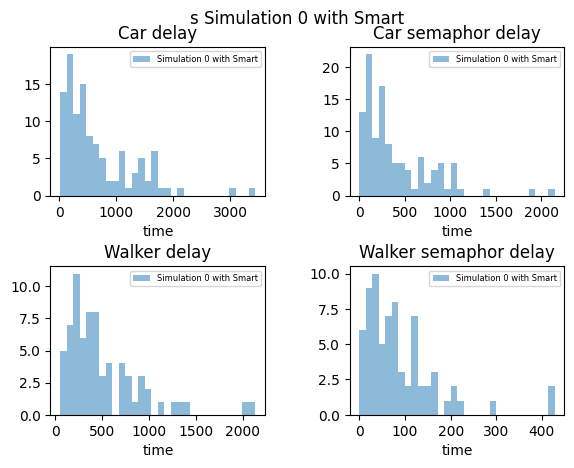

In [198]:
StatObject.plot_mixed_hist( [smarts[0]], False, False)

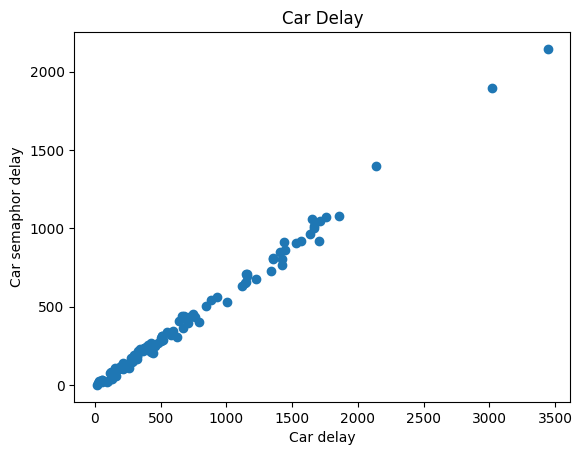

In [199]:
StatObject.plot_scatter("Car delay", "Car semaphor delay", smarts[0].values[CAR_DELAY], smarts[0].values[CAR_SEMAPHOR_DELAY], "Car Delay")

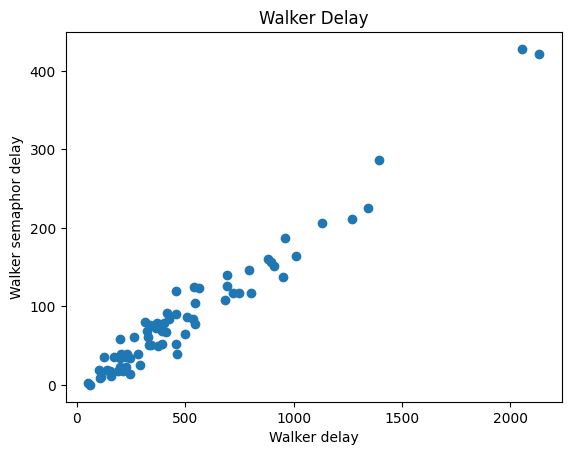

In [200]:
StatObject.plot_scatter("Walker delay", "Walker semaphor delay", smarts[0].values[WALKER_DELAY], smarts[0].values[WALKER_SEMAPHOR_DELAY], "Walker Delay")

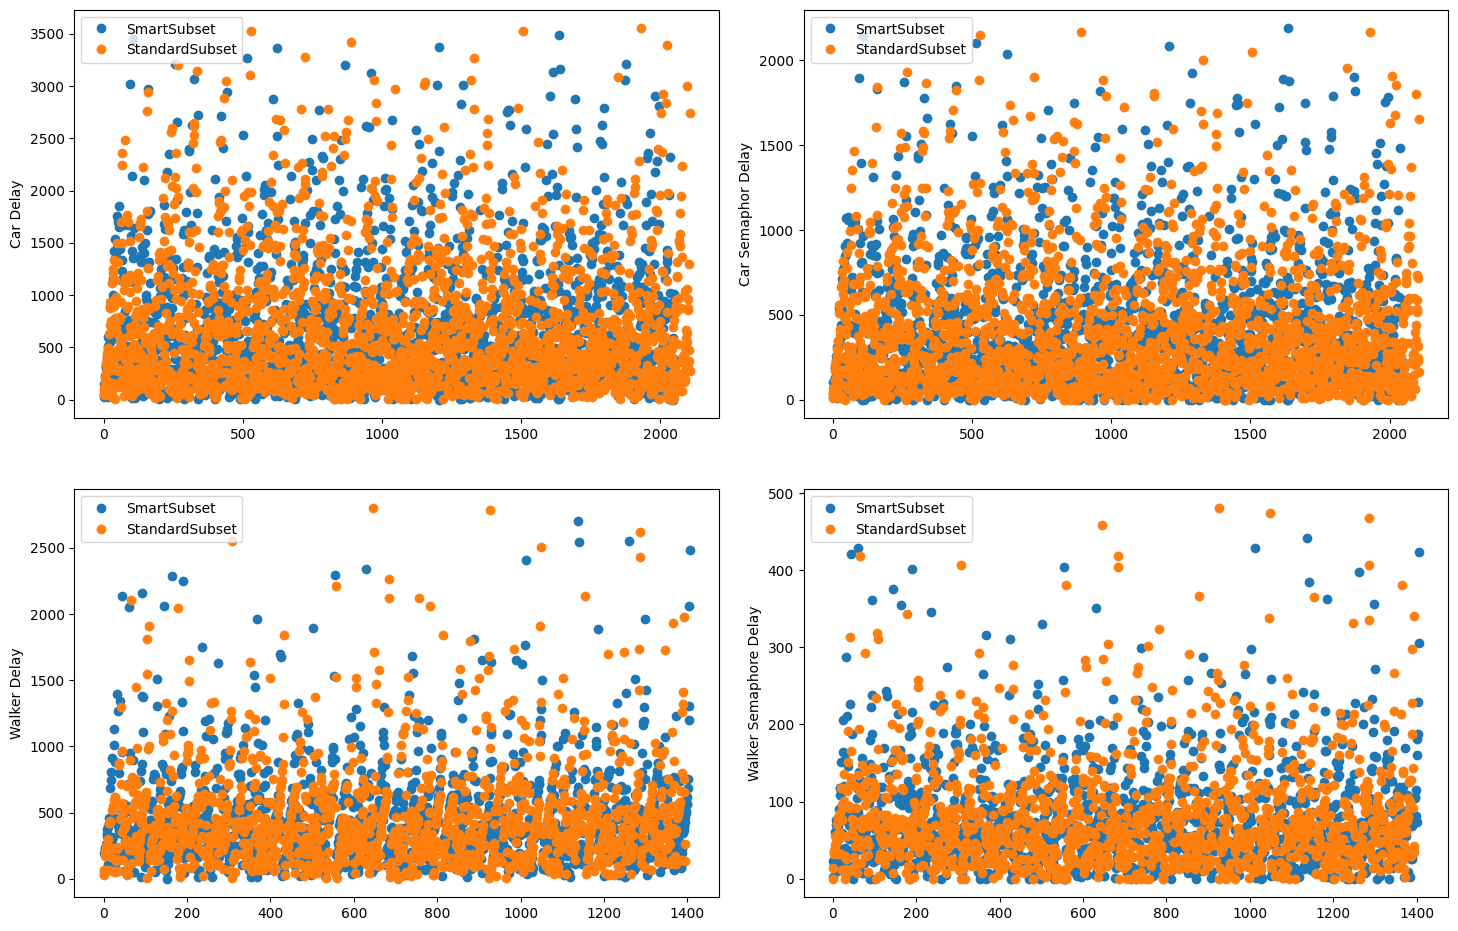

In [201]:
StatObject.plot_times_dot_histogram((smarts, "SmartSubset"), (standard, "StandardSubset"))

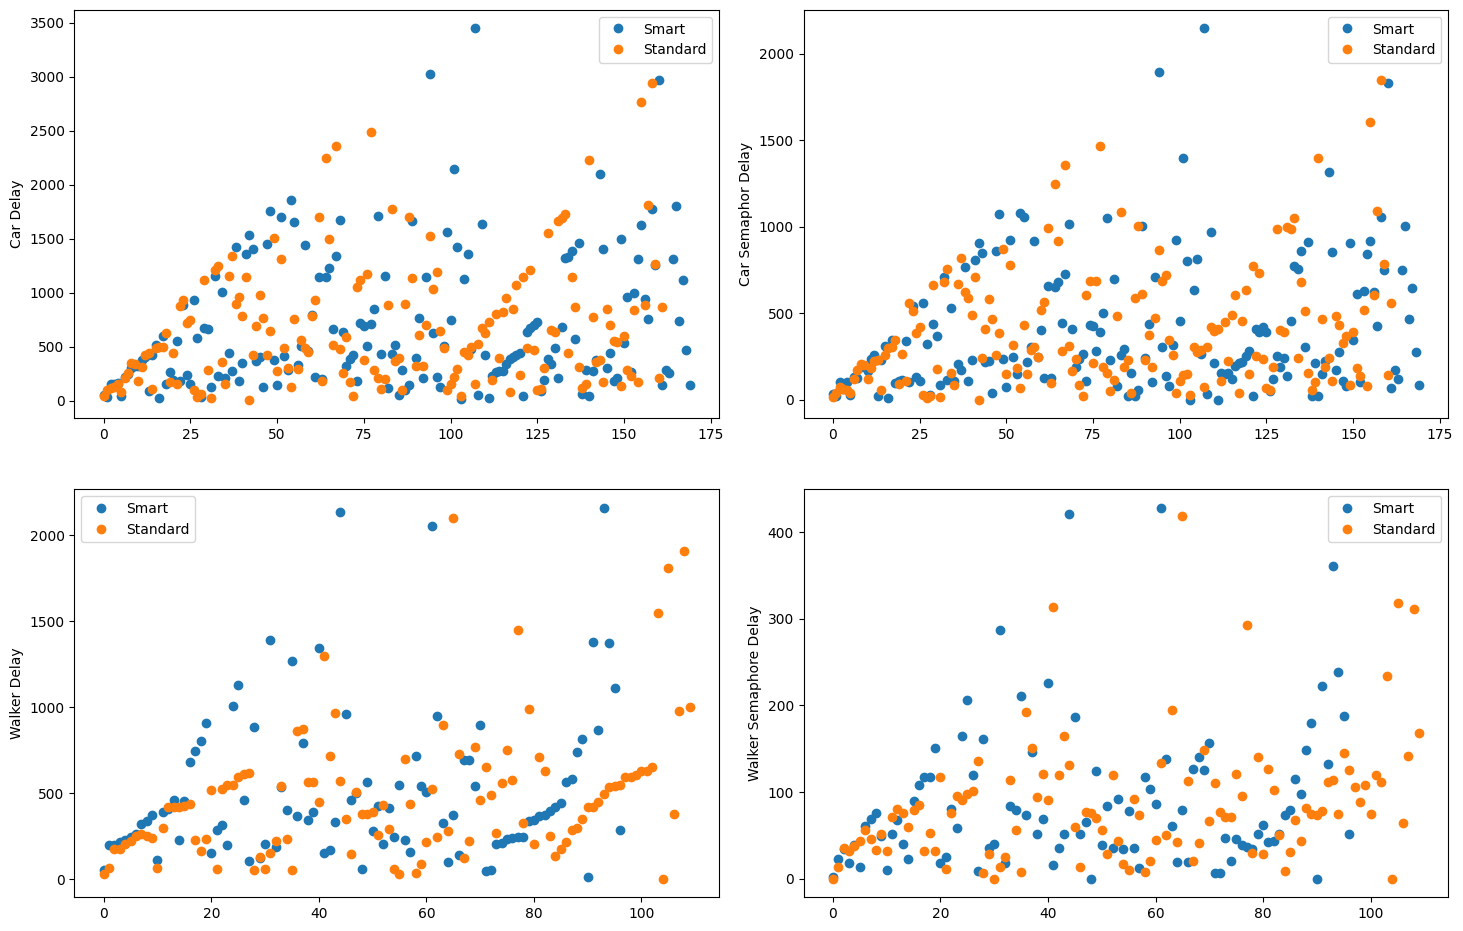

In [202]:
StatObject.plot_times_dot_histogram((smarts[:2], "Smart"), (standard[:2], "Standard"))


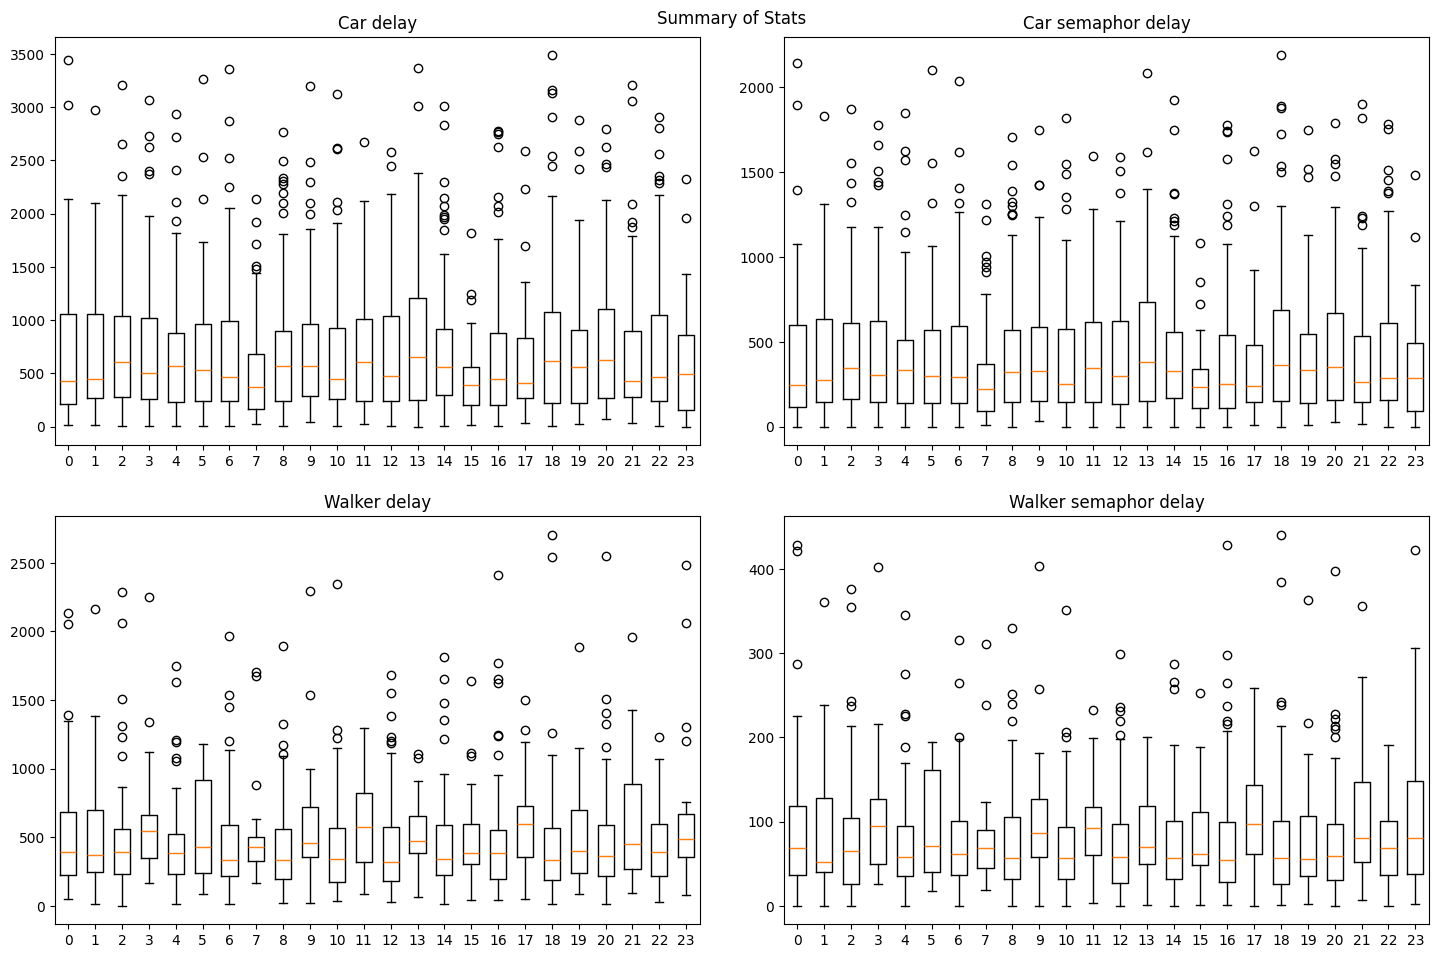

In [203]:
StatObject.plot_summary(smarts)

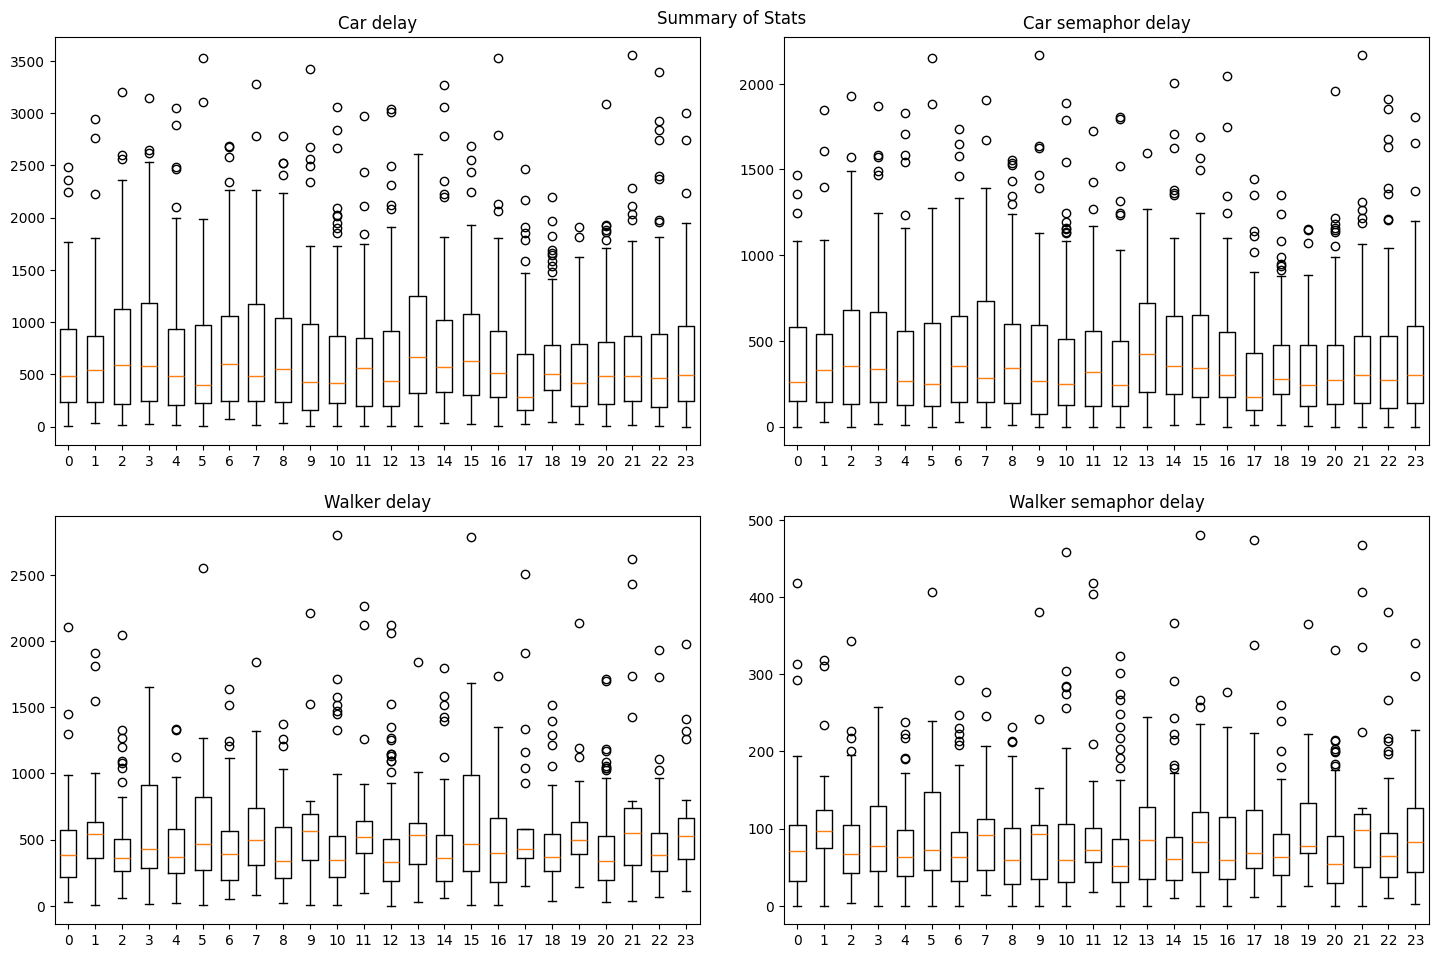

In [204]:
StatObject.plot_summary(standard)

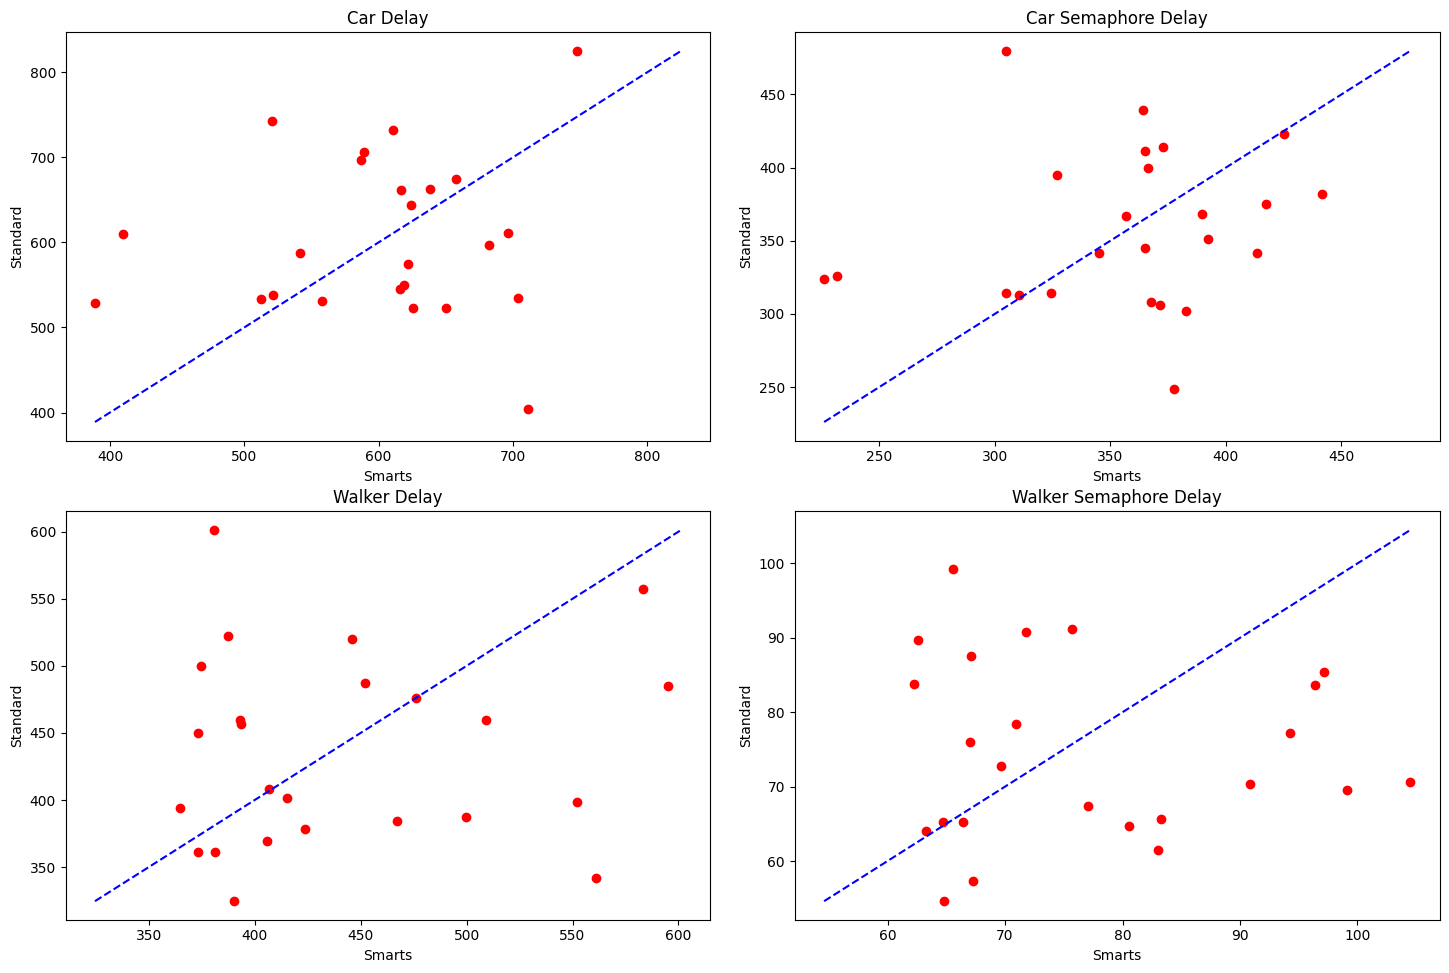

In [205]:
StatObject.average_plotter( (smarts, "Smarts"), (standard, "Standard"))

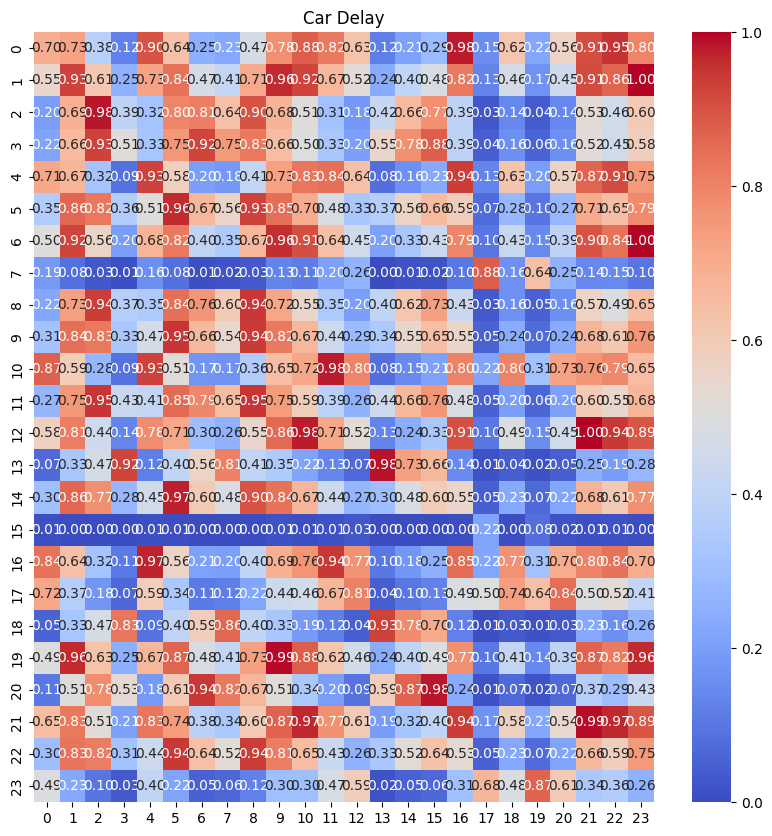

In [206]:
StatObject.plot_matrix_p_values_heat_map("Car Delay", StatObject.create_p_value_matrix_anov(smarts, standard, CAR_DELAY))

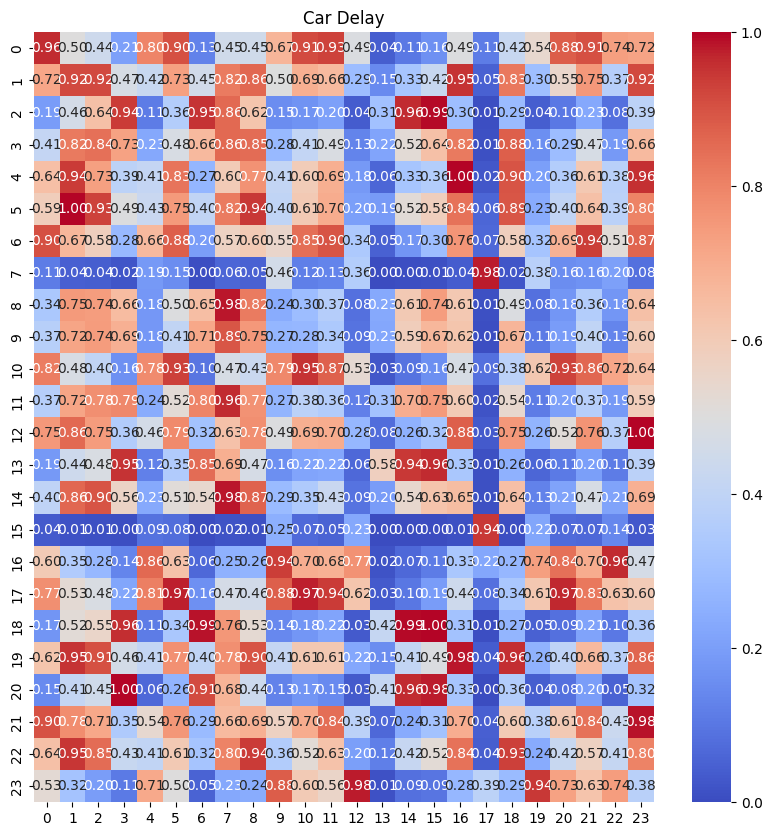

In [207]:
StatObject.plot_matrix_p_values_heat_map("Car Delay", StatObject.create_p_value_matrix_maan_whitney(smarts, standard, CAR_DELAY))